#Paquetes necesarios

In [1]:
import cv2
from ultralytics import YOLO
from matplotlib import pyplot as plt
import cv2  
import numpy as np
from skimage import transform

c:\Users\queol\anaconda3\envs\VC_P44\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


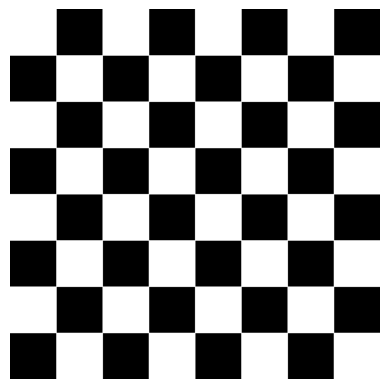

In [2]:
#Generamos un tablero de ajedrez el cual vamos a tomar de referencia para realizar la homografía
tablero = np.zeros((800,800,3), dtype = np.uint8)
for filas in range(8):
    for columnas in range(8):
        if ((filas + columnas) % 2) == 0: 
            cv2.rectangle(tablero,(filas*100,columnas*100),((filas+1)*100,(columnas+1)*100),(255,255,255),-1)
plt.axis("off")
plt.imshow(tablero) 
plt.show()

In [3]:
# Captura cuatro clics del ratón (parte uno)
def get_points(event, x, y, flags, param):
    puntos = param["points"]
    img = param["image"]

    if event == cv2.EVENT_LBUTTONDOWN:  # Botón izquierdo
        puntos.append((x, y))  
        
        # Dibujar en la imagen
        cv2.circle(img, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow(param["wname"], img)

        # Cuarto puntos, condición de parada
        if len(puntos) == 4:
            cv2.destroyAllWindows()
            print("Coordenadas imagen:", puntos)

def piece_place(x, y, param, img2):
    homo = param["tform"]
    # Transformar posición del ratón a imagen destino
    punto_A = np.array([[x, y]])  # Puntero 
    punto_B = homo(punto_A)  # Transformar a imagen destino
    # Dibuja en la imagen destino
    cv2.circle(img2, (int(punto_B[0][0]), int(punto_B[0][1])), 5, (0, 255, 0), -1)
    return punto_B

# Movimiento del puntero (parte 2)
def mouse_event(event, x, y, flags, param):
    homo = param["tform"]
    img = param["image"]

    if event == cv2.EVENT_MOUSEMOVE:  
        # Transformar posición del ratón a imagen destino
        punto_A = np.array([[x, y]])  # Puntero 
        punto_B = homo(punto_A)  # Transformar a imagen destino

        # Dibuja en la imagen destino
        imgtmp = img.copy()
        cv2.circle(imgtmp, (int(punto_B[0][0]), int(punto_B[0][1])), 5, (0, 255, 0), -1)
        cv2.imshow(param["wname"], imgtmp)



############## 1. RECOPILA LOS CUATRO PUNTOS EN AMBAS IMÁGENES
#Inicializa listas depuntos
puntosA = []
puntosB = [(0, 800), (800, 800), (0, 0), (800, 0)]

#Lee la nueva imagen, crea copia de trabajo
vista = cv2.imread('prueba3.jpg')
vistatmp = vista.copy()

#Mostramos el tablero de ajedrez de referencia
cv2.imshow('Mapa', tablero)
cv2.waitKey(0)

#Vista de la posicion a virtualizar
cv2.imshow("Vista", vistatmp) 
params = {
    "points": puntosA,
    "image": vistatmp, 
    "wname": "Vista"
}
cv2.setMouseCallback("Vista", get_points, params)
# Selecciona cuatro puntos o cierra ventana
cv2.waitKey(0)
cv2.destroyAllWindows()

#Transformación de los puntos https://scikit-image.org/docs/stable/auto_examples/transform/plot_transform_types.html
tform = transform.estimate_transform('projective', np.array(puntosA), np.array(puntosB))
tf_img = transform.warp(vista, tform.inverse, output_shape=(tablero.shape))

#Muestra imagen de entrada transformada
cv2.imshow("Homografía", tf_img) 
cv2.waitKey(-1)
cv2.destroyAllWindows()

###### 2. MUESTRA POSICIÓN DEL RATÓN EN EL TABLERO CON LA POSICION, EN LA IMAGEN DEL MAPA
# Mostrar las dos imágenes
cv2.imshow("Vista", vista)
cv2.imshow("Mapa", tablero)

params = {
    "tform": tform,
    "image": tablero, 
    "wname": "Mapa"
}

# Evento de movimiento del ratón
cv2.setMouseCallback("Vista", mouse_event, params)

cv2.waitKey(0)
cv2.destroyAllWindows()


Coordenadas imagen: [(67, 33), (33, 371), (314, 34), (372, 360)]



0: 416x416 1 black-king, 1 black-knight, 3 black-pawns, 1 black-rook, 1 white-bishop, 1 white-king, 1 white-knight, 3 white-pawns, 1 white-queen, 1 white-rook, 13.0ms
Speed: 1.0ms preprocess, 13.0ms inference, 6.0ms postprocess per image at shape (1, 3, 416, 416)
[['', '', '', 'black-king', '', '', '', ''], ['', '', '', 'black-pawn', '', '', '', ''], ['', '', '', '', '', 'black-pawn', '', ''], ['', '', '', '', '', '', 'black-pawn', ''], ['', '', '', 'white-rook', 'white-bishop', '', 'white-knight', ''], ['', 'white-queen', '', '', '', 'white-pawn', '', ''], ['black-rook', 'white-pawn', '', 'white-pawn', '', '', 'black-knight', ''], ['', '', '', 'white-king', '', '', '', '']]
3k4/3p4/5p2/6p1/3RB1N1/1Q3P2/rP1P2n1/3K4


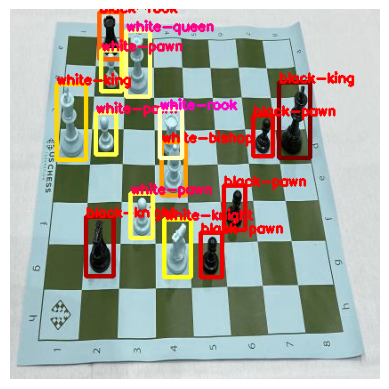

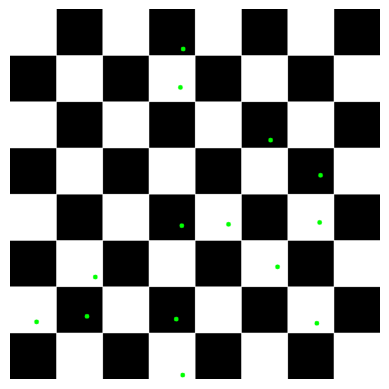

In [4]:
model = YOLO('yolo_chess_pieces.pt') #Contenedores

# Etiqueta de las distintas clases
classNames = ['bishop', 'black-bishop', 'black-king', 'black-knight', 'black-pawn', 'black-queen', 'black-rook', 'white-bishop', 'white-king', 'white-knight', 'white-pawn', 'white-queen', 'white-rook']

## Leer la imagen
img2 = cv2.imread('prueba3.jpg')  # Cambia esto por la ruta de tu imagen

# Tablero de Referencia
tablero_cenital = tablero.copy()

# Procesar con el modelo de piezas de ajedrez
results = model(img2)  

# Crear una matriz 8x8 con listas de listas
posicion = [['' for _ in range(8)] for _ in range(8)]

# Procesar las detecciones
for r in results:
    boxes = r.boxes
    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Coordenadas de la caja delimitadora
        cls = int(box.cls[0])  # Clase detectada (pieza de ajedrez)

        escala = int((cls / len(classNames)) * 255 * 3)
        R, G, B = (255, 255, escala - 255*2) if escala >= 255*2 else (255, escala - 255, 0) if escala >= 255 else (escala, 0, 0)

        # Dibuja y etiqueta la pieza detectada
        cv2.rectangle(img2, (x1, y1), (x2, y2), (R, G, B), 3)
        cv2.putText(img2, f"{classNames[cls]}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, B), 2)

        #Guarda la posición de la pieza y su clase en una matriz
        punto_B = piece_place(x1+5, y2-5, params, tablero_cenital)
        y = int((punto_B[0][0] // 100)) % 10  # Divide entre 100, luego toma el residuo de 10
        x = int((punto_B[0][1] // 100) % 10)  # Divide entre 100, luego toma el residuo de 10
        posicion[x][y]= classNames[cls]
       
print(posicion)

# Funcion para tranformar la matriz de posiciones y piezas a formato FEN
def board_to_fen(board_matrix):
    fen = []
    for row in board_matrix:
        row_fen = ''
        empty_count = 0
        for square in row:
            if square == '':  # Casilla vacía
                empty_count += 1
            else:  # Casilla ocupada por una pieza
                if empty_count > 0:
                    row_fen += str(empty_count)  # Añadir número de casillas vacías
                    empty_count = 0
                # Convertir las piezas al formato estándar FEN
                if(square[square.find('-') + 1]=='k' and square[square.find('-') + 2]=='n'):  
                    piece = square.split('-')[1][1]  # Tomar la primera letra después del guion  
                else: 
                    piece = square.split('-')[1][0]  # Tomar la primera letra después del guion
                if 'white' in square:
                    piece = piece.upper()  # Piezas blancas en mayúsculas
                else:
                    piece = piece.lower()  # Piezas negras en minúsculas
                row_fen += piece
        if empty_count > 0:
            row_fen += str(empty_count)  # Añadir número de casillas vacías al final de la fila
        fen.append(row_fen)
    return '/'.join(fen)

# Convertir la matriz al formato FEN
fen = board_to_fen(posicion)
print(fen)

plt.axis("off")
plt.imshow(img2)
plt.show()

plt.axis("off")
plt.imshow(tablero_cenital)
plt.show()
# Imprime el total de detecciones por clase

In [5]:
import pygame
import chess

# Inicializar pygame
pygame.init()

# Tamaño del tablero
BOARD_SIZE = 800
SQUARE_SIZE = BOARD_SIZE // 8

# Colores
LIGHT_COLOR = (240, 217, 181)
DARK_COLOR = (181, 136, 99)

# Inicializar ventana de pygame
screen = pygame.display.set_mode((BOARD_SIZE, BOARD_SIZE))
pygame.display.set_caption("Tablero de Ajedrez")

# Crear un tablero de ajedrez y cargar un FEN
fen_position = fen
board = chess.Board()
board.set_fen(fen)

# Función para dibujar el tablero
def draw_board(screen, board):
    # Dibujar las casillas
    for rank in range(8):
        for file in range(8):
            color = LIGHT_COLOR if (rank + file) % 2 == 0 else DARK_COLOR
            pygame.draw.rect(screen, color, (file * SQUARE_SIZE, rank * SQUARE_SIZE, SQUARE_SIZE, SQUARE_SIZE))
    
    # Dibujar las piezas
    pieces = board.piece_map()
    for square, piece in pieces.items():
        # Calcular las coordenadas de la pieza
        rank = 7 - chess.square_rank(square)
        file = chess.square_file(square)
        
        # Determinar la carpeta según el color de la pieza
        subdir = "white" if piece.color == chess.WHITE else "black"
        
        # Cargar la imagen de la pieza
        piece_img = pygame.image.load(f"piezas/{subdir}/{piece.symbol().lower()}.png")
        piece_img = pygame.transform.scale(piece_img, (SQUARE_SIZE, SQUARE_SIZE))
        
        # Dibujar la pieza en la pantalla
        screen.blit(piece_img, (file * SQUARE_SIZE, rank * SQUARE_SIZE))

# Bucle principal
running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
    
    # Dibujar el tablero
    draw_board(screen, board)
    
    # Actualizar la pantalla
    pygame.display.flip()

# Salir de pygame
pygame.quit()


pygame 2.6.1 (SDL 2.28.4, Python 3.9.20)
Hello from the pygame community. https://www.pygame.org/contribute.html
